# DSO 510 Project Data Prep for Final Model

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
df=pd.read_csv('https://raw.githubusercontent.com/MawadaMF/DSO510/main/Data/universities_cleaned.csv',index_col=0)

In [2]:
df.head()

,School_x,business_school,Acceptance Rate,Average Salary,Public(0) or Private(1),Reputation Score,Alumni,Tuition_Fees_17&18,Distance to Nearest City (Miles),Distance Far vs. Close
0,University of Pennsylvania (Wharton),Wharton,0.0649,80354,1,4.8,99000.0,53534.0,1.560704,Close
1,Washington University in St. Louis (Olin),Olin,0.0970,67115,1,4.1,21000.0,51533.0,235.684727,Far
2,University of California-Berkeley (Haas),Haas,0.0430,73302,0,4.6,39000.0,42184.0,11.315188,Close
3,Cornell University (Dyson),Dyson,0.0290,74493,1,4.3,NaN,52853.0,178.500330,Far
4,University of Michigan (Ross),Ross,0.1200,72268,0,4.6,52000.0,32451.5,35.657174,Close


In [3]:
# Remove unnecessary columns
df.drop(columns=['business_school','Distance Far vs. Close'],inplace=True)
df.columns

Index(['School_x', 'Acceptance Rate', 'Average Salary',
       'Public(0) or Private(1)', 'Reputation Score', 'Alumni',
       'Tuition_Fees_17&18', 'Distance to Nearest City (Miles)'],
      dtype='object')

In [4]:
# Reformat column names
df.rename(columns={'School_x':'school', 
                   'Acceptance Rate':'acceptance_rate',
                   'Average Salary':'average_salary', 
                   'Public(0) or Private(1)':'public_private',
                   'Reputation Score':'reputation_score',
                   'Alumni':'alumni',
                   'Tuition_Fees_17&18':'tuition_fees',
                   'Distance to Nearest City (Miles)':'distance_nearest_city'
                  },inplace=True)
df.head()

,school,acceptance_rate,average_salary,public_private,reputation_score,alumni,tuition_fees,distance_nearest_city
0,University of Pennsylvania (Wharton),0.0649,80354,1,4.8,99000.0,53534.0,1.560704
1,Washington University in St. Louis (Olin),0.0970,67115,1,4.1,21000.0,51533.0,235.684727
2,University of California-Berkeley (Haas),0.0430,73302,0,4.6,39000.0,42184.0,11.315188
3,Cornell University (Dyson),0.0290,74493,1,4.3,NaN,52853.0,178.500330
4,University of Michigan (Ross),0.1200,72268,0,4.6,52000.0,32451.5,35.657174


In [5]:
# Check for missing values
df.isna().sum()

school                    0
acceptance_rate           0
average_salary            0
public_private            0
reputation_score         34
alumni                   21
tuition_fees              0
distance_nearest_city     0
dtype: int64

In [6]:
# Calculate the median value for alumni
alumni_median=df['alumni'].median()
alumni_median

48000.0

In [7]:
# Fill missing values for alumni with the median value for alumni
df['alumni']=df['alumni'].fillna(alumni_median)
df['alumni'].isna().sum()

0

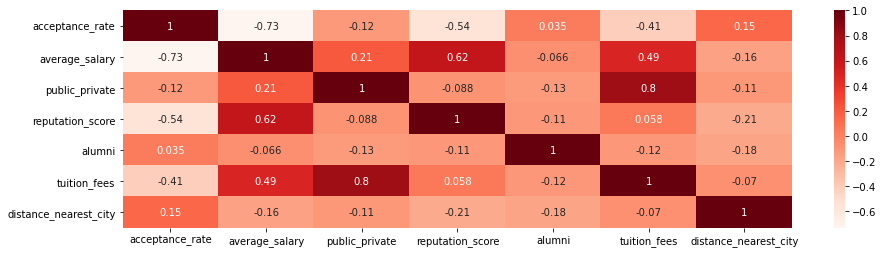

In [8]:
# Display the correlation matrix
plt.rcParams['figure.figsize']=(15,4)
sns.heatmap(df.corr(),cmap='Reds',annot=True);

In [9]:
# Create a subset of the data frame that excludes the rows with missing reputation scores
subset=df[df['reputation_score'].isna()==False]
len(subset)

54

In [10]:
# Average salary appears to be correlated with reputation score, so we will regress reputation score on average salary 
result = sm.ols(formula=" reputation_score ~ average_salary", 
                data=subset).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:       reputation_score   R-squared:                       0.382
Model:                            OLS   Adj. R-squared:                  0.371
Method:                 Least Squares   F-statistic:                     32.21
Date:                Fri, 03 Dec 2021   Prob (F-statistic):           6.24e-07
Time:                        15:30:26   Log-Likelihood:                -16.383
No. Observations:                  54   AIC:                             36.77
Df Residuals:                      52   BIC:                             40.74
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.5727      0.383      4.

In [11]:
# Create a subset of the data frame that only includes the rows with missing reputation scores
null_rep=df[df['reputation_score'].isna()]
len(null_rep)

34

In [12]:
# Display estimated coefficients 
result.params

Intercept         1.572737
average_salary    0.000035
dtype: float64

In [13]:
# Use the model to predict the missing values for reputation score
predictions = result.predict(exog=dict(average_salary=null_rep['average_salary']))
predictions

6     4.294392
21    3.770282
25    4.013212
34    3.620252
37    3.351705
38    3.691759
45    3.636863
46    3.647507
48    3.464638
50    3.247881
51    3.568427
52    3.397911
56    3.332336
57    3.438882
58    3.336419
64    3.774120
66    2.784006
67    3.566123
68    3.247881
69    3.568043
70    3.605838
71    3.061207
72    3.086160
73    3.208620
74    3.125979
75    3.340328
76    3.356765
77    3.300473
78    3.338339
79    3.432845
82    3.596869
84    3.460310
86    3.782985
87    3.484635
dtype: float64

In [14]:
# Fill in the missing values with the predicted values
df.loc[df['reputation_score'].isin(null_rep['reputation_score']),'reputation_score']=predictions
df['reputation_score'].isna().sum()

0

In [17]:
# Export the data
df.to_csv('regression_data.csv',index=False)